 <a href="https://colab.research.google.com/github/datastax/ragstack-ai/blob/main/examples/notebooks/langchain_multimodal_gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi modal RAG

In this notebook, we're going to show you how to use LangChain, AstraDB and Google Gemini Pro Vision model to perform multi-modal Retrieval Augmented Generation (RAG).

## Prerequisites

You will need a vector-enabled Astra database and a Google Cloud Platform account.

* Create an [Astra vector database](https://docs.datastax.com/en/astra-serverless/docs/getting-started/create-db-choices.html).
* Create a [GCP account](https://cloud.google.com/)
* Within your database, create an [Astra DB Access Token](https://docs.datastax.com/en/astra-serverless/docs/manage/org/manage-tokens.html) with Database Administrator permissions.
* Get your Astra DB Endpoint: 
  * `https://<ASTRA_DB_ID>-<ASTRA_DB_REGION>.apps.astra.datastax.com`


See the [Prerequisites](https://docs.datastax.com/en/ragstack/docs/prerequisites.html) page for more details.

In [3]:
!pip install -q google-cloud-aiplatform ragstack-ai --upgrade

In [ ]:
import os
from getpass import getpass

# Enter your settings for Astra DB:
os.environ["ASTRA_DB_API_ENDPOINT"] = input("Enter your Astra DB Endpoint: ")
os.environ["ASTRA_DB_APPLICATION_TOKEN"] = getpass("Enter your Astra DB Token: ")

### Configure Google Vertex AI Credentials:
You should see a popup that you must authorize to use your Google Cloud account. If a window doesn't pop up, it may be blocked by a popup blocker.

In [5]:
try:
    from google.colab import auth
    gcp_project_id = getpass(f"Enter GCP project ID:")
    !gcloud config set project {gcp_project_id}
    auth.authenticate_user()
except:
    import os
    if "GOOGLE_APPLICATION_CREDENTIALS" not in os.environ:
        credentials = getpass(f"Enter Google JSON credentials file: ")
        with open("/tmp/gcloud-account-key.json", "w") as f:
            f.write(credentials)
        os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/tmp/gcloud-account-key.json"


Enter Google JSON credentials file:  ········


### Use Gemini Pro Vision to identify an item
Let's see if Gemini Pro Vision can identify a part to my espresso machine and tell me where to get a replacement.  


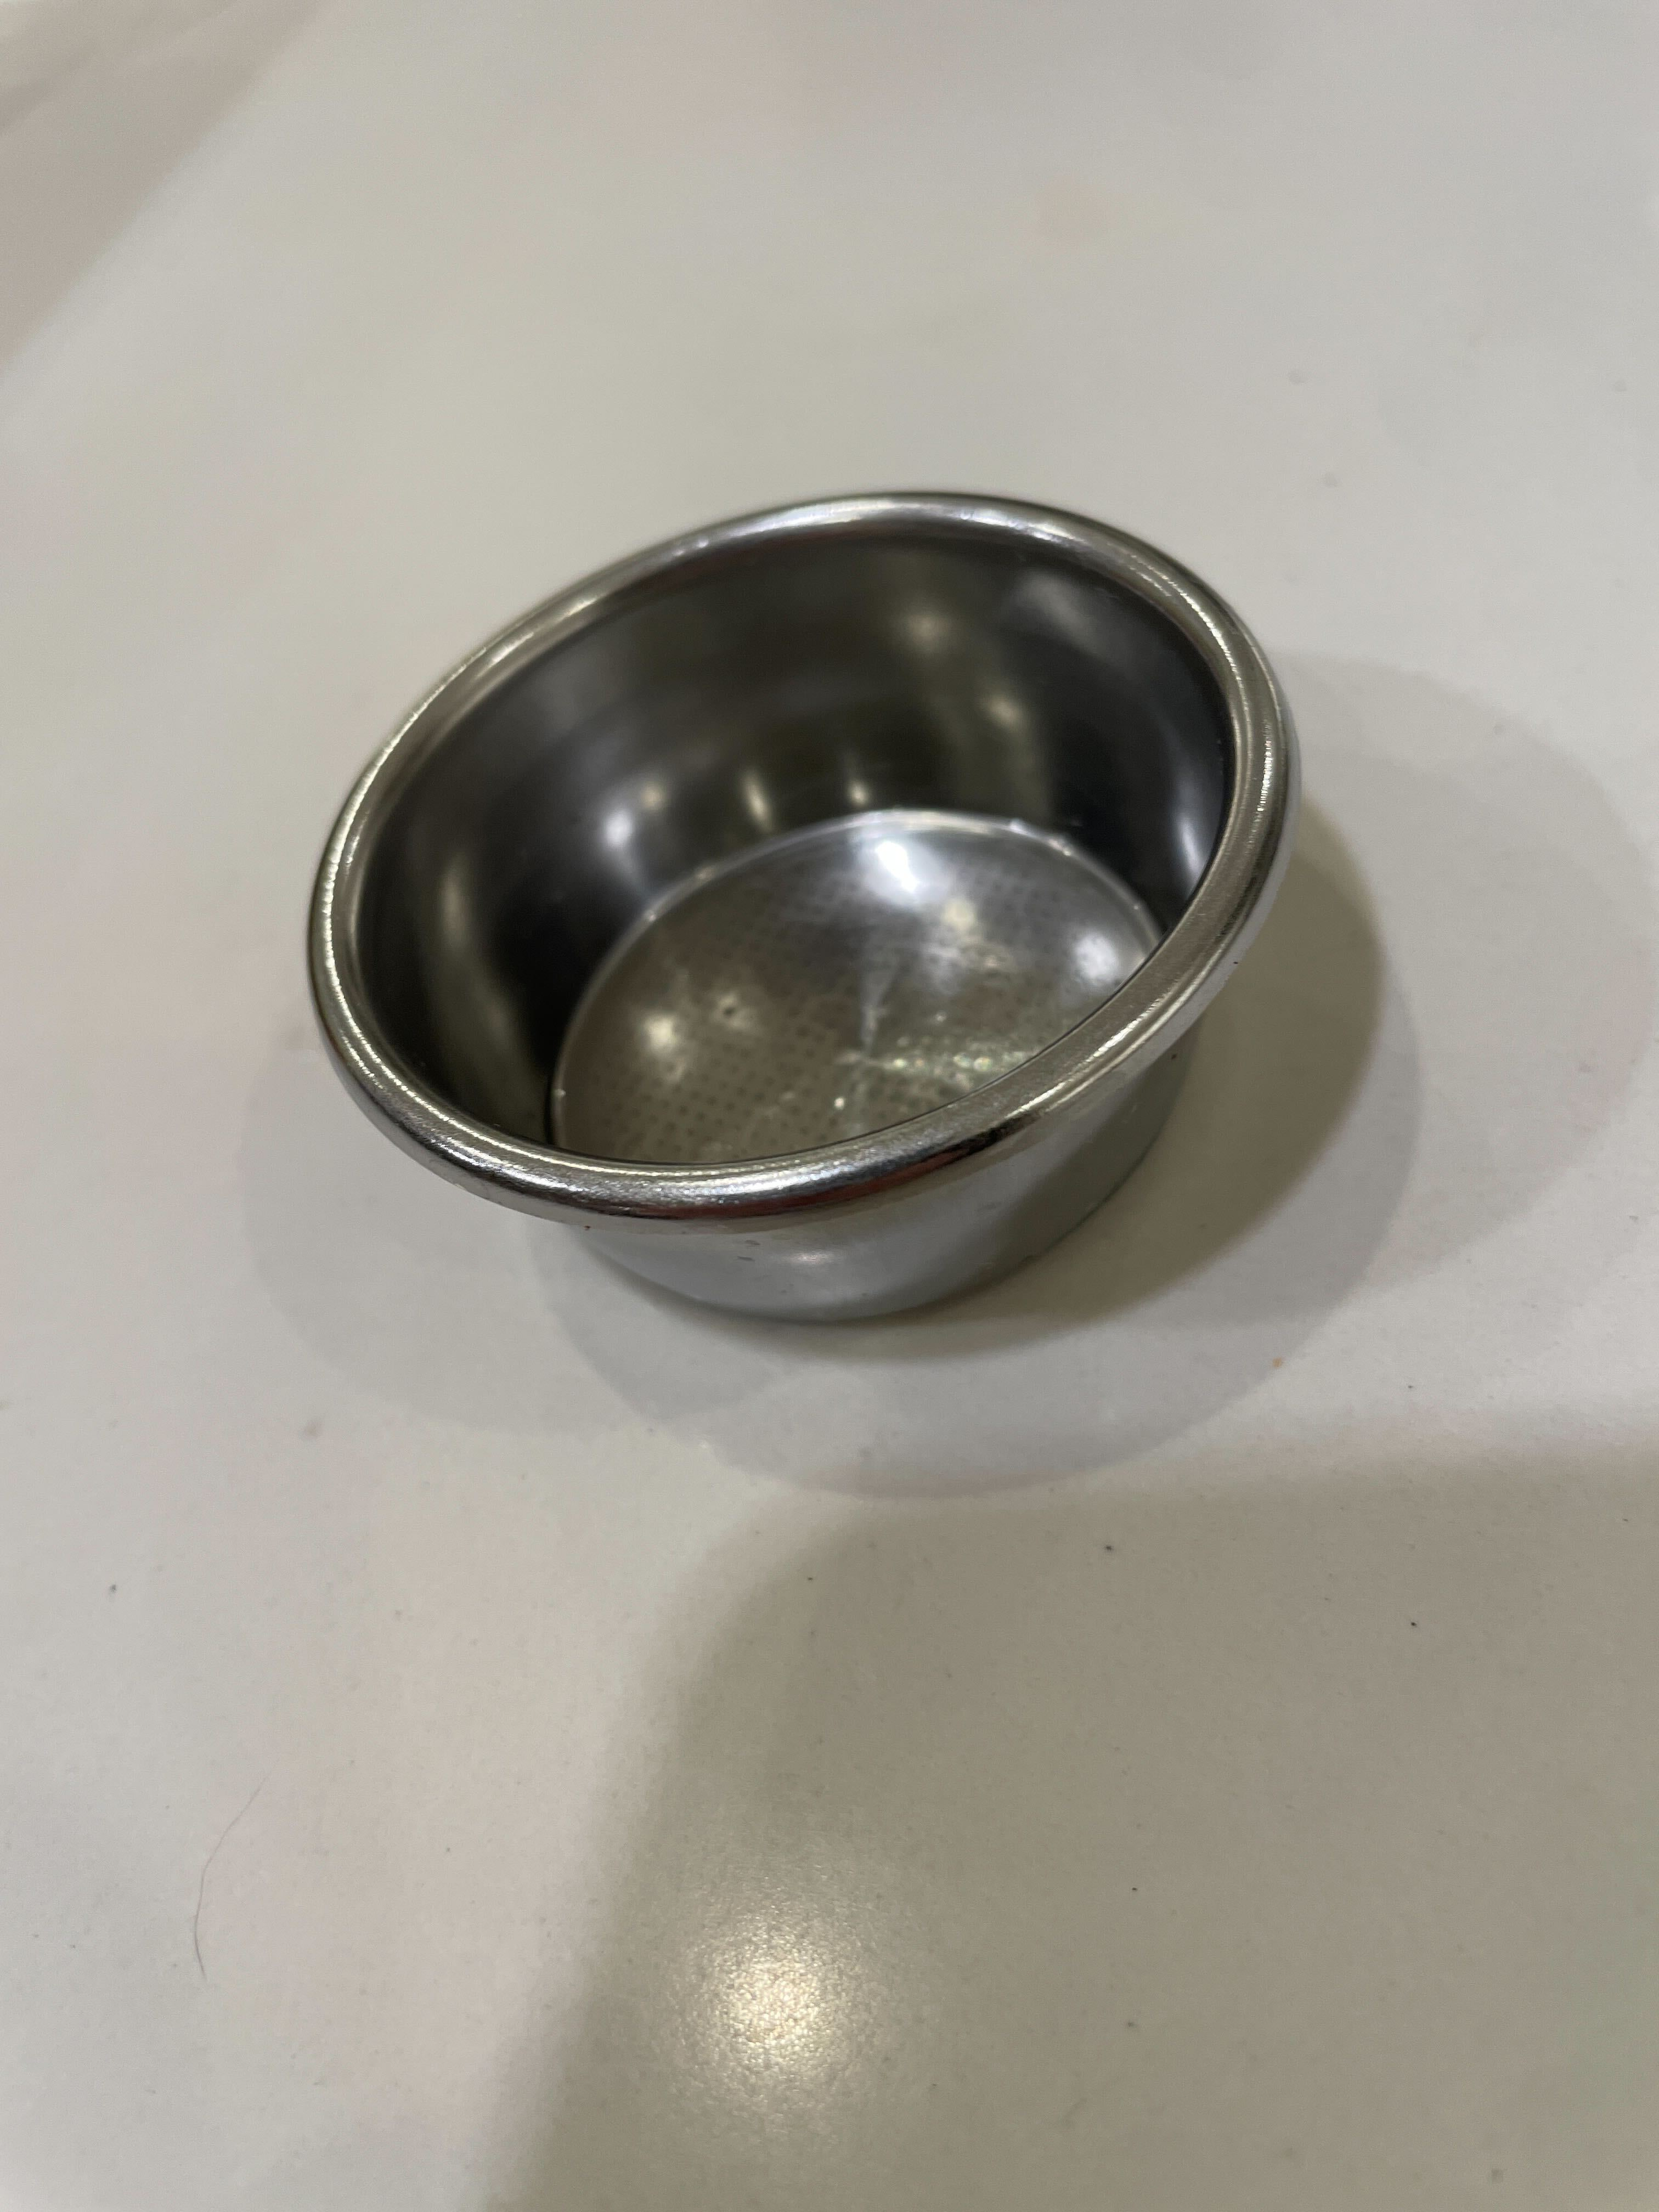

First, let's download this picture I took of the part. We'll save it in the Google Colab filesystem.

In [6]:
import requests 

source_img_data = requests.get('https://drive.google.com/uc?export=view&id=15ddcn-AIxpvRdWcFGvIr77XLWdo4Maof').content
with open('coffee_maker_part.png', 'wb') as handler:
  handler.write(source_img_data)

Now we're going to ask Gemini Pro Vision to identify the part in the picture.

In [13]:
from langchain.chat_models import ChatVertexAI
from langchain.schema.messages import HumanMessage
import os, sys

llm = ChatVertexAI(model_name="gemini-pro-vision")

from vertexai.vision_models import MultiModalEmbeddingModel, Image
image_message = {
    "type": "image_url",
    "image_url": {"url": "coffee_maker_part.png"},
}
text_message = {
    "type": "text",
    "text": "Describe the image and share a link to purchase a replacement",
}
message = HumanMessage(content=[text_message, image_message])

output = llm([message])
print(output.content)

 This is a bottomless portafilter basket. It is used to hold the ground coffee in a portafilter. You can purchase a replacement here: https://www.amazon.com/Bottomless-Portafilter-Basket-Compatible-Machines/dp/B09752K44C/


Amazingly, Gemini was able to correctly identify the part.  However, it gave us an out-of-date link to purchase a replacement.  Similarly, if the part was newer than the LLM, it would not have been able to identify it.  Luckily, with Retreival Augmented Generation, we can address both of these problems!

### Load a coffee parts product catalog into our Vector Store

We need to be able to search our own database for pictures that look similar to the one provided by the user.  To do that, let's create a database and download the referenced images.  


In [14]:
import pandas as pd

d = {'name': ["Saucer", "Saucer Ceramic", "Milk Jug Assembly", "Handle Steam Wand Kit (New Version From 0735 PDC)", "Spout Juice Small (From 0637 to 1041 PDC)", "Cleaning Steam Wand", "Jug Frothing", "Spoon Tamping 50mm", "Collar Grouphead 50mm", "Filter 2 Cup Dual Wall 50mm", "Filter 1 Cup 50mm", "Water Tank Assembly", "Portafilter Assembly 50mm", "Milk Jug Assembly", "Filter 2 Cup 50mm" ],
     'url': ["https://www.breville.com/us/en/parts-accessories/parts/sp0014946.html?sku=SP0014946", "https://www.breville.com/us/en/parts-accessories/parts/sp0014914.html?sku=SP0014914", "https://www.breville.com/us/en/parts-accessories/parts/sp0011391.html?sku=SP0011391", "https://www.breville.com/us/en/parts-accessories/parts/sp0010719.html?sku=SP0010719", "https://www.breville.com/us/en/parts-accessories/parts/sp0010718.html?sku=SP0010718", "https://www.breville.com/us/en/parts-accessories/parts/sp0003247.html?sku=SP0003247", "https://www.breville.com/us/en/parts-accessories/parts/sp0003246.html?sku=SP0003246", "https://www.breville.com/us/en/parts-accessories/parts/sp0003243.html?sku=SP0003243", "https://www.breville.com/us/en/parts-accessories/parts/sp0003232.html?sku=SP0003232", "https://www.breville.com/us/en/parts-accessories/parts/sp0003231.html?sku=SP0003231", "https://www.breville.com/us/en/parts-accessories/parts/sp0003230.html?sku=SP0003230", "https://www.breville.com/us/en/parts-accessories/parts/sp0003225.html?sku=SP0003225", "https://www.breville.com/us/en/parts-accessories/parts/sp0003216.html?sku=SP0003216", "https://www.breville.com/us/en/parts-accessories/parts/sp0001875.html?sku=SP0001875", "https://www.breville.com/us/en/parts-accessories/parts/sp0000166.html?sku=SP0000166"],
     'price': ["10.95", "4.99", "14.95", "8.95", "10.95", "6.95", "24.95", "8.95", "6.95", "12.95", "12.95", "14.95", "10.95", "16.95", "11.95"],
     'image': ["https://www.breville.com/content/dam/breville/us/catalog/products/images/sp0/sp0014946/tile.jpg", "https://www.breville.com/content/dam/breville/us/catalog/products/images/sp0/sp0014914/tile.jpg", "https://www.breville.com/content/dam/breville/us/catalog/products/images/sp0/sp0011391/tile.jpg", "https://www.breville.com/content/dam/breville/ca/catalog/products/images/sp0/sp0010719/tile.jpg", "https://www.breville.com/content/dam/breville/ca/catalog/products/images/sp0/sp0010718/tile.jpg", "https://www.breville.com/content/dam/breville/ca/catalog/products/images/sp0/sp0003247/tile.jpg", "https://assets.breville.com/cdn-cgi/image/width=400,format=auto/Spare+Parts+/Espresso+Machines/BES250/SP0003246/SP0003246_IMAGE1_400X400.jpg", "https://assets.breville.com/cdn-cgi/image/width=400,format=auto/Spare+Parts+/Espresso+Machines/ESP8/SP0003243/SP0003243_IMAGE1_400X400.jpg", "https://assets.breville.com/cdn-cgi/image/width=400,format=auto/Spare+Parts+/Espresso+Machines/ESP8/SP0003232/SP0003232_IMAGE1_400x400.jpg", "https://www.breville.com/content/dam/breville/au/catalog/products/images/sp0/sp0003231/tile.jpg", "https://www.breville.com/content/dam/breville/au/catalog/products/images/sp0/sp0003230/tile.jpg", "https://www.breville.com/content/dam/breville/ca/catalog/products/images/sp0/sp0003225/tile.jpg", "https://www.breville.com/content/dam/breville/ca/catalog/products/images/sp0/sp0003216/tile.jpg", "https://www.breville.com/content/dam/breville/au/catalog/products/images/sp0/sp0001875/tile.jpg", "https://www.breville.com/content/dam/breville/us/catalog/products/images/sp0/sp0000166/tile.jpg"]}
df = pd.DataFrame(data=d)
df


,name,url,price,image
0,Saucer,https://www.breville.com/us/en/parts-accessori...,10.95,https://www.breville.com/content/dam/breville/...
1,Saucer Ceramic,https://www.breville.com/us/en/parts-accessori...,4.99,https://www.breville.com/content/dam/breville/...
2,Milk Jug Assembly,https://www.breville.com/us/en/parts-accessori...,14.95,https://www.breville.com/content/dam/breville/...
3,Handle Steam Wand Kit (New Version From 0735 PDC),https://www.breville.com/us/en/parts-accessori...,8.95,https://www.breville.com/content/dam/breville/...
4,Spout Juice Small (From 0637 to 1041 PDC),https://www.breville.com/us/en/parts-accessori...,10.95,https://www.breville.com/content/dam/breville/...
5,Cleaning Steam Wand,https://www.breville.com/us/en/parts-accessori...,6.95,https://www.breville.com/content/dam/breville/...
6,Jug Frothing,https://www.breville.com/us/en/parts-accessori...,24.95,https://assets.breville.com/cdn-cgi/image/widt...
7,Spoon Tamping 50mm,https://www.breville.com/us/en/parts-accessori...,8.95,https://assets.breville.com/cdn-cgi/image/widt...
8,Collar Grouphead 50mm,https://www.breville.com/us/en/parts-accessori...,6.95,https://assets.breville.com/cdn-cgi/image/widt...
9,Filter 2 Cup Dual Wall 50mm,https://www.breville.com/us/en/parts-accessori...,12.95,https://www.breville.com/content/dam/breville/...


Next, we'll create vector embeddings of each of the product images using Google's Multi-Modal Embedding Model and save the data in AstraDB.  

In [ ]:
import json, requests, os
from vertexai.preview.vision_models import MultiModalEmbeddingModel, Image
from astrapy.db import AstraDB

model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding@001")

# Initialize our vector db
astra_db = AstraDB(token=os.getenv("ASTRA_DB_APPLICATION_TOKEN"), api_endpoint=os.getenv("ASTRA_DB_API_ENDPOINT"))
collection = astra_db.create_collection(collection_name="coffee_shop_ecommerce", dimension=1408)

for i in range(len(df)):
  name = df.loc[i, "name"]
  image = df.loc[i, "image"]
  price = df.loc[i, "price"]
  url = df.loc[i, "url"]

  # Download this product's image and save it to the Colab filesystem.
  # In a production system this binary data would be stored in Google Cloud Storage
  img_data = requests.get(image).content
  with open(f'{name}.png', 'wb') as handler:
    handler.write(img_data)

  # load the image from filesystem and compute the embedding value
  img = Image.load_from_file(f'{name}.png')
  embeddings = model.get_embeddings(image=img, contextual_text=name)

  try:
    # add to the AstraDB Vector Database
    collection.insert_one({
        "_id": i,
        "name": name,
        "image": image,
        "url": url,
        "price": price,
        "$vector": embeddings.image_embedding,
      })
  except Exception as error:
    # if you've already added this record, skip the error message
    error_info = json.loads(str(error))
    if error_info[0]['errorCode'] == "DOCUMENT_ALREADY_EXISTS":
      print(f"Document {name} already exists in the database. Skipping.")

### Multimodal RAG
Now let's ask the LLM the same question but this time we'll perform a vector search against AstraDB using the same image to supply the LLM with relevant products in the prompt.

In [26]:
# Embed the similar item
img = Image.load_from_file('coffee_maker_part.png')
embeddings = model.get_embeddings(image=img, contextual_text="A espresso machine part")

# Perform the vector search against AstraDB Vector
documents = collection.vector_find(
    embeddings.image_embedding,
    limit=3,
)

related_products_csv = "name, image, price, url\n"
for doc in documents:
  related_products_csv += f"{doc['name']}, {doc['image']}, {doc['price']}, {doc['url']},\n"

image_message = {
    "type": "image_url",
    "image_url": {"url": "coffee_maker_part.png"},
}
text_message = {
    "type": "text",
    "text": f"""Given this image, please choose a possible replacement. Include link and price. Here are possible replacements: {related_products_csv}""",
}
message = HumanMessage(content=[text_message, image_message])
output = llm([message])
print(output.content)

 Filter 2 Cup 50mm, https://www.breville.com/content/dam/breville/us/catalog/products/images/sp0/sp0000166/tile.jpg, 11.95, https://www.breville.com/us/en/parts-accessories/parts/sp0000166.html?sku=SP0000166
